In [1]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]



In [2]:

def sim_run(G_VAL, LR, SEED, NB_STEPS=50000):
    """
    INPUTS:
    G_VAL: float, global coupling
    LR: array, learning rate (Homogeneous or heterogenos. Decay will be calcualted for each region with this)
    SEED: int, random seed
    OUTPUTS:
    rates_dyn: np.array, dynamic of rates
    rates_inh_dyn: np.array, dynamic of inhibitory rates
    bold_dyn: np.array, dynamic of BOLD signal
    fic_t_dyn: np.array, dynamic of FIC

    """
    
    params = dmf.default_params(C=C)
    fit_res = np.load("./data/fit_res_3-44.npy")
    b = fit_res[0] # First element is the slope
    a = fit_res[1]
    params['G'] = G_VAL
    params['seed'] = SEED
    params['obj_rate'] = 3.44
    DECAY = np.exp(a+np.log(LR)*b)    
    params['lr_vector'] = LR
    params['taoj_vector'] =  DECAY
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params["with_decay"] = True
    params["with_plasticity"] = True
    params['return_bold'] = False
    params["return_fic"] = True
    params["return_rate"] = True
    rates_dyn, rates_inh_dyn, _, fic_t_dyn = dmf.run(params, NB_STEPS)
    return rates_dyn, rates_inh_dyn, fic_t_dyn


import numpy as np

def vectorize_along_axis(axis=0):
    def decorator(func):
        def wrapper(data, *args, **kwargs):
            # if the data is 1D, just call the function directly
            if data.ndim == 1:
                return func(data, *args, **kwargs)
            # otherwise, apply the function along the specified axis
            return np.apply_along_axis(func, axis, data, *args, **kwargs)
        return wrapper
    return decorator

@vectorize_along_axis(axis=0)
def get_autcorr(rates):
    """Get the autocorrelation function from a 1D rates vector."""
    signal = rates - np.mean(rates)
    # Calculate autocorrelation function (full convolution)
    autocorr = np.correlate(signal, signal, mode='full')
    # Normalize: divide by the variance and length of the signal
    autocorr = autocorr / (np.var(signal) * len(signal))
    # Only keep the second half (non-negative lags)
    autocorr = autocorr[len(signal)-1:]
    return autocorr




## K means clustering on the autocorrelation

In [53]:
G_VAL = 3.5
LR_HOMO = 100
LR_HOMO_VEC = np.ones(200)*LR_HOMO
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 5000
NB_STEPS = 15000

In [54]:
rates, _, _ = sim_run(G_VAL, LR_HOMO_VEC, SEED,NB_STEPS)
rates = rates[:,BURNOUT:]
autocorr_all = get_autcorr(rates)
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_autocorr = pca.fit_transform(autocorr_all)
# Now we have a 200x5 pca_autocorr and the exaplined variance go from 50% to 25%


In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
silhouette = []
n_clusters_list = [2,3,4,5,6,7,8]
for n_cluster in n_clusters_list:
    cluster_labels = KMeans(n_clusters=n_cluster).fit_predict(pca_autocorr)
    silouhette_avg = silhouette_score(pca_autocorr,cluster_labels)
    silhouette.append(silouhette_avg)
    print(f"For n_cluster = {n_cluster} - Got silhuoette = {silouhette_avg}")


For n_cluster = 2 - Got silhuoette = 0.9840995391760403
For n_cluster = 3 - Got silhuoette = 0.6010088239845794
For n_cluster = 4 - Got silhuoette = 0.5791026104985608
For n_cluster = 5 - Got silhuoette = 0.5997002249827702
For n_cluster = 6 - Got silhuoette = 0.2093326684742368
For n_cluster = 7 - Got silhuoette = 0.22605882998064664
For n_cluster = 8 - Got silhuoette = 0.23164042488603315


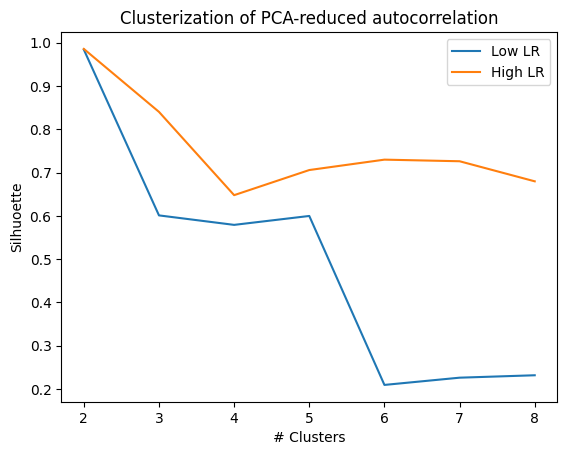

In [59]:
from cProfile import label


plt.plot(range(2,9),silhouette_low_lr,label="Low LR")
plt.plot(range(2,9),silhouette_high_lr,label="High LR")
plt.xlabel("# Clusters")
plt.ylabel("Silhuoette")
plt.title("Clusterization of PCA-reduced autocorrelation")
plt.legend()
plt.show()

In [57]:
silhouette_low_lr = silhouette.copy()

## Density clustering

# Homogeneous with low LR

NCLUS=1


Text(0.5, 0.92, 'LR_HOMO = 100 - dc = 0.08 - ci_alpha = 0.1')

) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


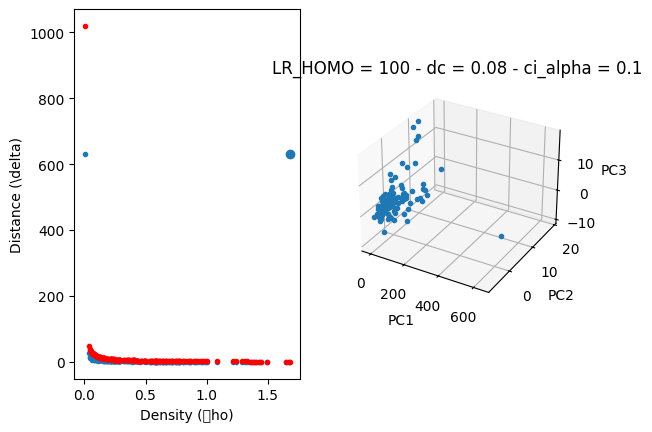

In [175]:
from enum import auto
import density_clustering.dclus as dclust
from matplotlib.pyplot import cm
from scipy.spatial import distance

G_VAL = 3.5
LR_HOMO = 100
LR_HOMO_VEC = np.ones(200)*LR_HOMO
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
NB_STEPS = 15000

rates, _, _ = sim_run(G_VAL, LR_HOMO_VEC, SEED,NB_STEPS)
rates = rates[:,BURNOUT:]
AUTOCORR_TMAX = 3000
autocorr_all = get_autcorr(rates)
autocorr_all = autocorr_all[:,:AUTOCORR_TMAX]
autocorr_all = zscore(autocorr_all,0)

numpcs = 6
ishalo = 0
dc = 0.08 # neighborhood parameter. EXPLORE WITH THIS. fOR VALUES <.04 will generate an error for this data
ci_alpha = 0.1 # threshold for centroids detection. EXPLORE THIS AS WELL
# PCA
distmat,proj_data = dclust.pca_and_distance(autocorr_all.T,numpcs)

rho,delta,centid,cluslabels,halolabels,threshold = dclust.clustering_by_density(distmat,dc,ci_alpha,ishalo)
nclus = int(np.max(cluslabels))
print(f"NCLUS={nclus}")
color = cm.tab20(np.linspace(0, 1, nclus))
dclust.plot_clustering_summary(delta,rho,centid,cluslabels,threshold,proj_data,color)
plt.title(f"LR_HOMO = {LR_HOMO} - dc = {dc} - ci_alpha = {ci_alpha}")

# Homogeneous with high LR

NCLUS=1


Text(0.5, 0.92, 'LR_HOMO = 10000 - dc = 0.08 - ci_alpha = 0.1')

) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


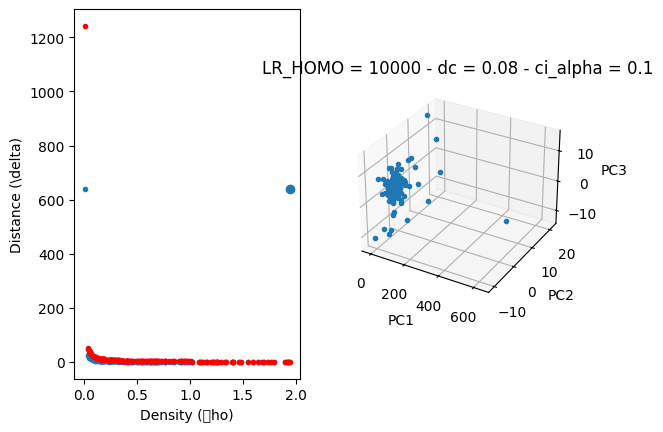

In [176]:
import density_clustering.dclus as dclust
from matplotlib.pyplot import cm
from scipy.spatial import distance

G_VAL = 3.5
LR_HOMO = 10000
LR_HOMO_VEC = np.ones(200)*LR_HOMO
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 5000
NB_STEPS = 15000

rates, _, _ = sim_run(G_VAL, LR_HOMO_VEC, SEED,NB_STEPS)
rates = rates[:,BURNOUT:]
AUTOCORR_TMAX = 3000
autocorr_all = get_autcorr(rates)
autocorr_all = autocorr_all[:,:AUTOCORR_TMAX]
autocorr_all = zscore(autocorr_all,0)

numpcs = 6
ishalo = 0
dc = 0.08 # neighborhood parameter. EXPLORE WITH THIS. fOR VALUES <.04 will generate an error for this data
ci_alpha = 0.1 # threshold for centroids detection. EXPLORE THIS AS WELL

distmat,proj_data = dclust.pca_and_distance(autocorr_all.T,numpcs)

rho,delta,centid,cluslabels,halolabels,threshold = dclust.clustering_by_density(distmat,dc,ci_alpha,ishalo)
nclus = int(np.max(cluslabels))
print(f"NCLUS={nclus}")
color = cm.tab20(np.linspace(0, 1, nclus))
dclust.plot_clustering_summary(delta,rho,centid,cluslabels,threshold,proj_data,color)

plt.title(f"LR_HOMO = {LR_HOMO} - dc = {dc} - ci_alpha = {ci_alpha}")

In [136]:
nclus

1

# Heterogeneous with 1 High LR

NCLUS=1


Text(0.5, 0.92, 'LR_HOMO = 10000 - LR_HET = 100 - dc = 0.08 - ci_alpha = 0.1')

) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


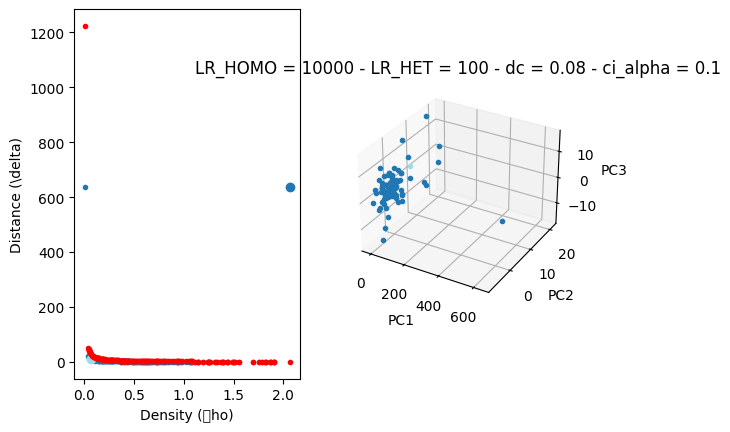

In [232]:
import density_clustering.dclus as dclust
from matplotlib.pyplot import cm


G_VAL = 3.5
LR_HOMO = 10000
LR_HOMO_VEC = np.ones(200)*LR_HOMO
LR_HET = 100
SELECTED_REGIONS = [10]
LR_HET_VEC = LR_HOMO_VEC.copy()
LR_HET_VEC[SELECTED_REGIONS] = LR_HET
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
NB_STEPS = 15000

rates, _, _ = sim_run(G_VAL, LR_HOMO_VEC, SEED,NB_STEPS)
rates = rates[:,BURNOUT:]
AUTOCORR_TMAX = 3000
autocorr_all = get_autcorr(rates)
autocorr_all = autocorr_all[:,:AUTOCORR_TMAX]
#autocorr_all = zscore(autocorr_all,0)

numpcs = 6
ishalo = 0
dc = 0.08 # neighborhood parameter. EXPLORE WITH THIS. fOR VALUES <.04 will generate an error for this data
ci_alpha = 0.1 # threshold for centroids detection. EXPLORE THIS AS WELL
# PCA
distmat,proj_data = dclust.pca_and_distance(autocorr_all.T,numpcs)

rho,delta,centid,cluslabels,halolabels,threshold = dclust.clustering_by_density(distmat,dc,ci_alpha,ishalo)
nclus = int(np.max(cluslabels))
print(f"NCLUS={nclus}")
color = cm.tab20(np.linspace(0, 1, nclus))
cluslabels[10]=2
centid = list(centid)
centid.append(10)
centid = np.array(centid)
color = cm.tab20(np.linspace(0, 1, 2))
dclust.plot_clustering_summary(delta,rho,centid,cluslabels,threshold,proj_data,color)

plt.title(f"LR_HOMO = {LR_HOMO} - LR_HET = {LR_HET} - dc = {dc} - ci_alpha = {ci_alpha}")

In [ ]:
freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
max_freq_id = np.argmax(psd[:,:100],axis=1)
max_freqs = freqs[max_freq_id]
max_power = np.max(psd[:,:100],axis=1)
plt.scatter(max_freqs,max_power)
plt.xlim([0, 25])
plt.show()

In [238]:
psd.shape

(200, 4001)

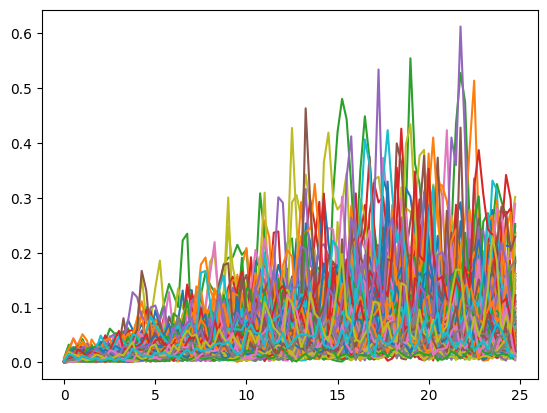

In [244]:
plt.plot(freqs[:100],psd[:,:100].T)
plt.show()

# Groups of heterogeneity

In [119]:
from bct import score_wu, rich_club_wu
# Select the nodes with the hihgest node strength from SC matrix C
node_strength = np.mean(C,axis=0)
# Get the 10 lowest regions
most_connected = np.argsort(node_strength)[::-1]

score_levels = np.arange(0.02,1.6,0.01)
score_idxs = []
for level in score_levels:
    score, sn = score_wu(C,level)
    # Get the indices from score that have > 0 values
    if sn>0:
        score_idxs.append(np.where(np.sum(score,axis=0) > 0)[0]) 


# Most connected regions

NCLUS=1


Text(0.5, 0.92, 'LR_HOMO = 10000 - LR_HET = 100 - dc = 0.08 - ci_alpha = 0.2')

) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


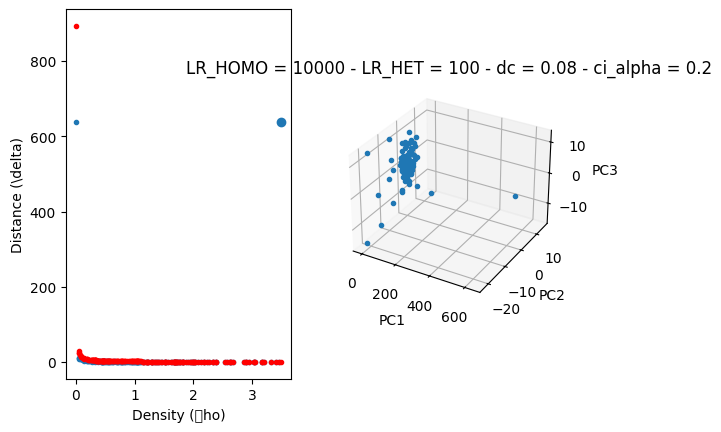

In [292]:
from tkinter.tix import AUTO
from scipy.spatial import distance
from scipy.stats import zscore
import density_clustering.dclus as dclust
from matplotlib.pyplot import cm


G_VAL = 3.5
LR_HOMO = 10000
LR_HOMO_VEC = np.ones(200)*LR_HOMO
LR_HET = 100
SELECTED_REGIONS = most_connected[:10]
LR_HET_VEC = LR_HOMO_VEC.copy()
LR_HET_VEC[SELECTED_REGIONS] = LR_HET
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 3000
NB_STEPS = 15000

rates, _, _ = sim_run(G_VAL, LR_HET_VEC, SEED,NB_STEPS)
rates = rates[:,BURNOUT:]
autocorr_all = get_autcorr(rates[:,:AUTOCORR_TMAX])

numpcs = 3
ishalo = 0
dc = 0.08 # neighborhood parameter. EXPLORE WITH THIS. fOR VALUES <.04 will generate an error for this data
ci_alpha = 0.2 # threshold for centroids detection. EXPLORE THIS AS WELL
# PCA
distmat,proj_data = dclust.pca_and_distance(autocorr_all.T,numpcs)

rho,delta,centid,cluslabels,halolabels,threshold = dclust.clustering_by_density(distmat,dc,ci_alpha,ishalo)
nclus = int(np.max(cluslabels))
print(f"NCLUS={nclus}")
color = cm.tab20(np.linspace(0, 1, nclus))
dclust.plot_clustering_summary(delta,rho,centid,cluslabels,threshold,proj_data,color)
plt.title(f"LR_HOMO = {LR_HOMO} - LR_HET = {LR_HET} - dc = {dc} - ci_alpha = {ci_alpha}")

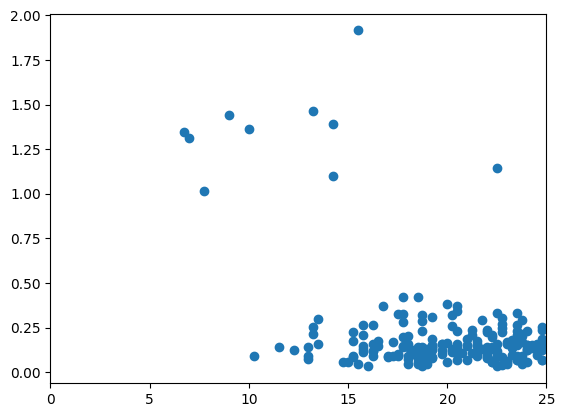

In [293]:
freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
max_freq_id = np.argmax(psd[:,:100],axis=1)
max_freqs = freqs[max_freq_id]
max_power = np.max(psd[:,:100],axis=1)
plt.scatter(max_freqs,max_power)
plt.xlim([0, 25])
plt.show()

# S-core regions

NCLUS=2


) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


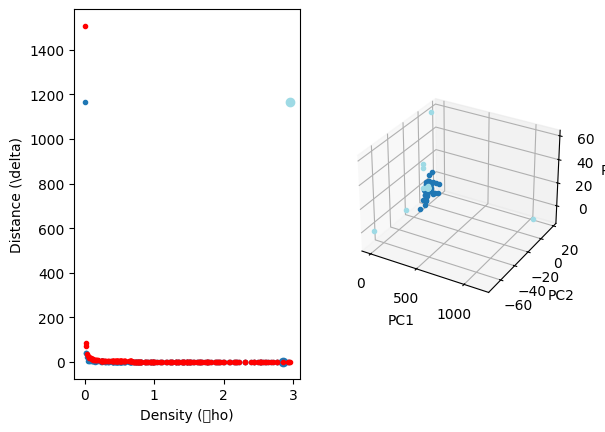

In [294]:
from scipy.spatial import distance
from scipy.stats import zscore
import density_clustering.dclus as dclust
from matplotlib.pyplot import cm


G_VAL = 3.5
LR_HOMO = 10000
LR_HOMO_VEC = np.ones(200)*LR_HOMO
LR_HET = 100
highest_score = score_idxs[-1]
SELECTED_REGIONS = highest_score
LR_HET_VEC = LR_HOMO_VEC.copy()
LR_HET_VEC[SELECTED_REGIONS] = LR_HET
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
NB_STEPS = 15000

rates, _, _ = sim_run(G_VAL, LR_HET_VEC, SEED,NB_STEPS)
rates = rates[:,BURNOUT:]
AUTOCORR_TMAX = 5000
autocorr_all = get_autcorr(rates)

numpcs = 3
ishalo = 0
dc = 0.08 # neighborhood parameter. EXPLORE WITH THIS. fOR VALUES <.04 will generate an error for this data
ci_alpha = 0.2 # threshold for centroids detection. EXPLORE THIS AS WELL
# PCA
distmat,proj_data = dclust.pca_and_distance(autocorr_all.T,numpcs)

rho,delta,centid,cluslabels,halolabels,threshold = dclust.clustering_by_density(distmat,dc,ci_alpha,ishalo)
nclus = int(np.max(cluslabels))
print(f"NCLUS={nclus}")
color = cm.tab20(np.linspace(0, 1, nclus))
dclust.plot_clustering_summary(delta,rho,centid,cluslabels,threshold,proj_data,color)

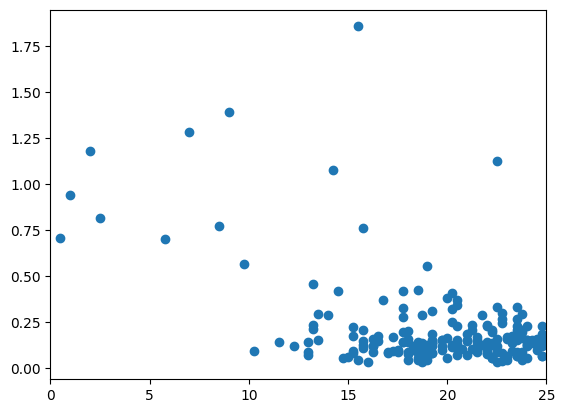

In [295]:
freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
max_freq_id = np.argmax(psd[:,:100],axis=1)
max_freqs = freqs[max_freq_id]
max_power = np.max(psd[:,:100],axis=1)
plt.scatter(max_freqs,max_power)
plt.xlim([0, 25])
plt.show()

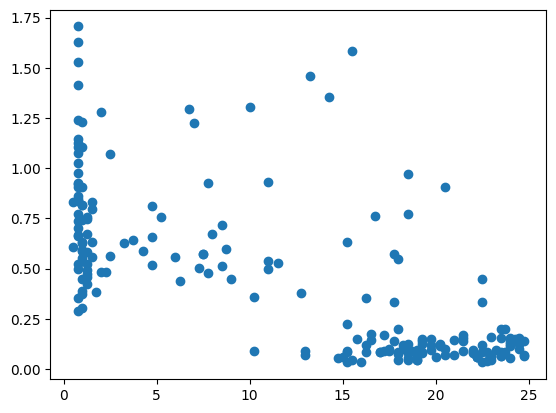

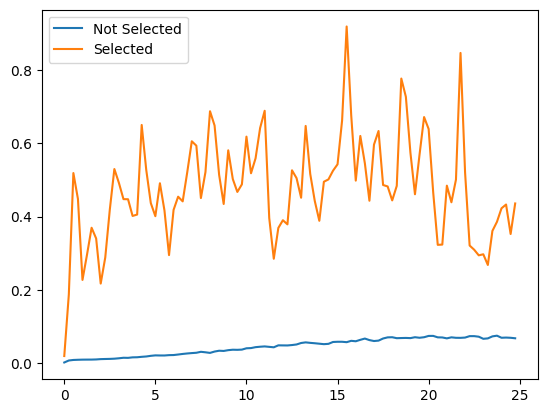

In [269]:
NOT_SELECTED = np.setdiff1d(np.arange(200),SELECTED_REGIONS)
plt.plot(freqs[:100],np.mean(psd[NOT_SELECTED,:100],axis=0),label="Not Selected")
plt.plot(freqs[:100],np.mean(psd[SELECTED_REGIONS,:100],axis=0),label="Selected")
plt.legend()
plt.show()
